# Troop Booth Signups Analysis

This notebook loads data from `data/2025_booth_signups_trimmed.csv` (which contains columns such as **Troop**, **Troop Email**, **Slot Start Time**, **Slot End Time**, **When Selected Date**, **When Selected Time**, **User Selecting**) and performs statistical analysis focused on the number of booth signup events per troop. In addition, the notebook identifies and labels potential outliers in the distribution of booth signup counts.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load the Data

The data file is located at `data/2025_booth_signups_trimmed.csv`. It is assumed that the file has a header with the following columns:

- Troop
- Troop Email
- Slot Start Time
- Slot End Time
- When Selected Date
- When Selected Time
- User Selecting

Let's load the data into a pandas DataFrame.

In [4]:
# Define the path to the data file
data_file = 'data/2025_booth_signups_unit_trimmed.csv'

# Load the CSV file (with header)
df = pd.read_csv(data_file)

# Display the first few rows
print("Data preview:")
df.head()

Data preview:


,Troop,Troop Email,Slot Start Time,Slot End Time,When Selected Date,When Selected Time,User Selecting
0,3822,naldaz08@yahoo.com,2000/01/01 14:00:00,2000/01/01 16:00:00,2025/01/16 20:14:31,2025/01/16 20:14:31,naldaz08@yahoo.com
1,3822,naldaz08@yahoo.com,2000/01/01 16:00:00,2000/01/01 18:00:00,2025/01/16 20:14:31,2025/01/16 20:14:31,naldaz08@yahoo.com
2,3065,j.savage13@hotmail.com,2000/01/01 10:00:00,2000/01/01 12:00:00,2025/01/14 20:02:38,2025/01/14 20:02:38,kaitlyn.redfield@gmail.com
3,3065,j.savage13@hotmail.com,2000/01/01 14:00:00,2000/01/01 16:00:00,2025/01/14 20:03:02,2025/01/14 20:03:02,kaitlyn.redfield@gmail.com
4,3799,azchesko@gmail.com,2000/01/01 10:00:00,2000/01/01 12:00:00,2025/01/14 20:02:12,2025/01/14 20:02:12,azchesko@gmail.com


## 2. Data Preparation

We will convert the time columns to datetime objects. (Note: The sample times use a format like `2000/01/01 14:00:00`, which we assume is consistent for the time fields.)

In our analysis we focus on counting the number of booth signup events per troop (each row is one event).

In [5]:
# Convert time columns to datetime objects
df['Slot Start Time'] = pd.to_datetime(df['Slot Start Time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
df['Slot End Time']   = pd.to_datetime(df['Slot End Time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# If desired, you can also convert the When Selected Date and When Selected Time
df['When Selected Date'] = pd.to_datetime(df['When Selected Date'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
df['When Selected Time'] = pd.to_datetime(df['When Selected Time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Troop               510 non-null    int64         
 1   Troop Email         510 non-null    object        
 2   Slot Start Time     510 non-null    datetime64[ns]
 3   Slot End Time       510 non-null    datetime64[ns]
 4   When Selected Date  507 non-null    datetime64[ns]
 5   When Selected Time  507 non-null    datetime64[ns]
 6   User Selecting      510 non-null    object        
dtypes: datetime64[ns](4), int64(1), object(2)
memory usage: 28.0+ KB


## 3. Aggregating Booth Signups per Troop

Since each row represents one booth signup event, we can count the number of events per troop by grouping on the **Troop** column.

In [6]:
# Group by Troop and count the number of signup events per troop
troop_counts = df.groupby('Troop').size().reset_index(name='Num_Booths')

# Sort by number of booths (signup events)
troop_counts.sort_values('Num_Booths', ascending=False, inplace=True)
print("Booth signup counts per troop:")
print(troop_counts)

# Compute descriptive statistics
desc_stats = troop_counts['Num_Booths'].describe()
print("\nDescriptive statistics for booth signups per troop:")
print(desc_stats)

Booth signup counts per troop:
    Troop  Num_Booths
20   3829          85
0     872          68
16   3822          59
21   3839          31
12   3475          29
6    2820          22
7    2877          20
15   3819          19
11   3315          19
8    3065          18
17   3824          16
9    3296          16
22   3997          16
13   3630          13
1    2554          11
23   4208          11
19   3828          10
24   7223           9
14   3799           8
5    2674           8
10   3312           6
4    2626           5
25   9670           4
3    2603           3
18   3827           3
2    2570           1

Descriptive statistics for booth signups per troop:
count    26.000000
mean     19.615385
std      20.632163
min       1.000000
25%       8.000000
50%      14.500000
75%      19.750000
max      85.000000
Name: Num_Booths, dtype: float64


## 4. Outlier Detection

We use the Interquartile Range (IQR) method to identify potential outliers in the number of booth signup events per troop.

An outlier is defined as a troop whose count is below Q1 - 1.5×IQR or above Q3 + 1.5×IQR.

In [7]:
Q1 = troop_counts['Num_Booths'].quantile(0.25)
Q3 = troop_counts['Num_Booths'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

# Identify outlier troops
outliers = troop_counts[(troop_counts['Num_Booths'] < lower_bound) | (troop_counts['Num_Booths'] > upper_bound)]
print("\nOutlier troops (by number of booth signups):")
print(outliers)

Q1: 8.0, Q3: 19.75, IQR: 11.75
Lower bound: -9.625, Upper bound: 37.375

Outlier troops (by number of booth signups):
    Troop  Num_Booths
20   3829          85
0     872          68
16   3822          59


## 5. Visualization with Outlier Labels

Below is a boxplot of the booth signup counts per troop. In addition, we overlay a stripplot (jittered points) for each troop and label the outlier points with the corresponding troop number.

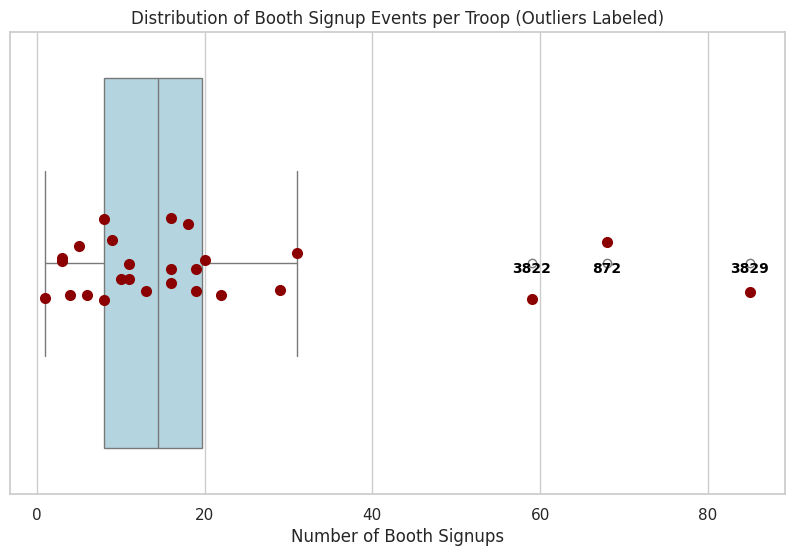

In [8]:
plt.figure(figsize=(10,6))

# Create a boxplot of the booth signup counts
ax = sns.boxplot(x='Num_Booths', data=troop_counts, color='lightblue')

# Overlay a stripplot of individual troop counts
sns.stripplot(x='Num_Booths', data=troop_counts, color='darkred', size=8, jitter=True, ax=ax)

# Annotate outliers with their Troop number
for index, row in troop_counts.iterrows():
    if row['Num_Booths'] < lower_bound or row['Num_Booths'] > upper_bound:
        # The y-value: use a slight vertical offset (here 0) because stripplot adds jitter.
        ax.text(row['Num_Booths'], 0.02, str(row['Troop']), horizontalalignment='center',
                color='black', weight='bold', fontsize=10)

plt.title('Distribution of Booth Signup Events per Troop (Outliers Labeled)')
plt.xlabel('Number of Booth Signups')
plt.show()

## 6. Save the Summary Data

Finally, we save the aggregated summary (the number of booth signup events per troop) to a CSV file for further use.

In [9]:
output_file = 'troop_booth_summary.csv'
troop_counts.to_csv(output_file, index=False)
print(f"Summary data saved to {output_file}")

Summary data saved to troop_booth_summary.csv


## Conclusion

In this notebook we have:

- Loaded the troop booth signup data from `data/2025_booth_signups_trimmed.csv`
- Prepared the data by converting time fields to datetime
- Aggregated the data to compute the number of signup events per troop
- Computed descriptive statistics and used the IQR method to identify potential outliers
- Visualized the distribution with a boxplot and overlayed a stripplot, labeling the outlier troops with their troop numbers
- Saved the aggregated summary to a CSV file

Feel free to extend or modify this analysis as needed.